In [1]:
data_dir = '/home/ubuntu/data/iceberg'

import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.layers.merge import Add, Concatenate
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import cv2
import keras
import os
from keras.callbacks import TensorBoard

from keras import __version__
print(__version__)


Using TensorFlow backend.


2.1.1


In [2]:
np.random.seed(1234)

def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

#         imgs.append(np.dstack((band_1, band_2, band_3)))
        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [3]:
df_train = pd.read_json(os.path.join(data_dir, 'train.json'))
Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])
ids = np.array(df_train['id'])

df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

Ytrain = Ytrain[idx_tr[0]]
ids = ids[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]
Xinc = df_train.inc_angle[idx_tr[0]]

In [31]:
pred_test_all_train = model2.predict([Xtrain, Xinc])

In [37]:
pred_test_all_train.shape, to_categorical(Ytrain).shape

((1471, 2), (1471, 2))

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_img_set(img_num):
    # randomly needs the squeeze false parameter if you only want one row of images
    f,ax = plt.subplots(1,3,figsize=(20,10), squeeze=False)
    ax[0][0].imshow(X_valid[img_num, :, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(X_valid[img_num, :, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(X_valid[img_num, :, :,2]), ax[0][2].set_title("avg band1,2")

In [39]:
data = np.concatenate((pred_test_all_train, to_categorical(Ytrain)), axis=1)

In [40]:
df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])

In [47]:
data.shape

(1471, 4)

In [69]:
df[df.a.round()!=df.c]

,a,b,c,d
76,0.400356,0.587336,1.0,0.0
106,0.338466,0.639648,1.0,0.0
157,0.056280,0.943594,1.0,0.0
220,0.345999,0.646319,1.0,0.0
403,0.264426,0.726629,1.0,0.0
603,0.086805,0.915477,1.0,0.0
667,0.035510,0.964211,1.0,0.0
767,0.013120,0.986107,1.0,0.0
770,0.053444,0.945903,1.0,0.0
774,0.372396,0.613247,1.0,0.0


In [68]:
for i, row in df[df.a.round()!=df.c].iterrows():
    print(str(i) + ': ' + str(ids[i]))

76: ebff4efc
106: 0113e164
157: 2f881d78
220: a68bcde2
403: 56c8639e
603: 617bf094
667: fd1f0c9b
767: 43135317
770: 93beaaaa
774: e8200704
854: ba57a170
868: 37f93675
911: 4bc45388
922: aaef2165
960: 6fa53d41
973: 7052a617
1053: 047bb667
1106: 4b453753
1126: 94ddcb93
1145: 420de859
1155: 601cdc58
1198: 0b44f893
1350: ec5c461e
1381: 2164c343


In [54]:
img_num = 76
print('1 is : ' + str(to_categorical(1)) + ',  0 is : ' + str(to_categorical(0)))
print(Ytrain[img_num]) 
print(to_categorical(Ytrain[img_num]))
#is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. 

1 is : [ 0.  1.],  0 is : [ 1.]
0
[ 1.]


In [55]:
pred_test_all_train[img_num], ids[img_num]

(array([ 0.40035629,  0.58733612], dtype=float32), 'ebff4efc')

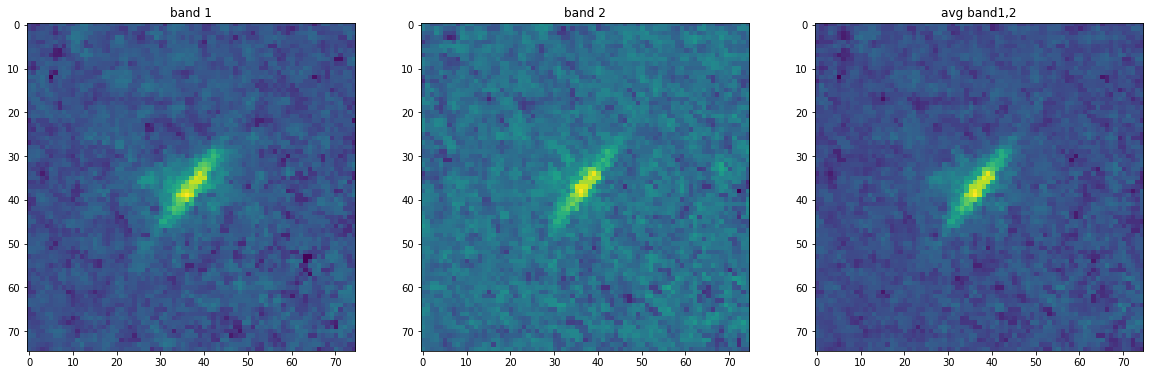

In [56]:
plot_img_set(img_num)

In [44]:
df_train[df_train['id']==valid_ids[img_num]]

NameError: name 'img_num' is not defined

In [33]:
data.shape, valid_ids.shape

NameError: name 'data' is not defined

In [4]:
ids.shape, Ytrain.shape

((1471,), (1471,))

In [5]:
Xtrain[1,:,:,1].max()

0.72976856454753891

In [6]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_inc_train, X_inc_valid, Y_train, Y_valid, train_ids, valid_ids = train_test_split(Xtrain,
                                    Xinc, Ytrain, ids, random_state=777, train_size=0.9, test_size=0.1)

X_train.shape, X_valid.shape, X_inc_train.shape, X_inc_valid.shape, Y_train.shape, Y_valid.shape, train_ids.shape, valid_ids.shape

((1323, 75, 75, 3),
 (148, 75, 75, 3),
 (1323,),
 (148,),
 (1323,),
 (148,),
 (1323,),
 (148,))

In [7]:
X_train = get_more_images(X_train)
X_inc_train = np.concatenate((X_inc_train,X_inc_train,X_inc_train))
Y_train = np.concatenate((Y_train,Y_train,Y_train))
train_ids = np.concatenate((train_ids,train_ids,train_ids))

X_train.shape, X_inc_train.shape, Y_train.shape, train_ids.shape

((3969, 75, 75, 3), (3969,), (3969,), (3969,))

In [8]:
batch_size = 256
        
tbCallBack = TensorBoard(log_dir='/home/ubuntu/data/tensorboardlogs/', histogram_freq=0, write_graph=True, write_images=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, epsilon=1e-4, mode='min')

In [9]:
# pseudo labelling using model with best score on kaggle LB 

In [10]:
preds_dir = '/home/ubuntu/data/iceberg/results/final_preds/mix'
pred_test = pd.read_csv(preds_dir + '/cnn_train_0.96_best.csv').as_matrix()


In [11]:
df_test = pd.read_json(os.path.join(data_dir, 'test.json'))
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
Xtest_inc = df_test.inc_angle
Xtest_id = df_test.id

In [12]:
Xtest.shape, Xtest_inc.shape, pred_test.shape, Xtest_id.shape

((8424, 75, 75, 3), (8424,), (8424, 2), (8424,))

In [13]:
# this is the correct way round with [:,1]
idx_pred_1 = (np.where(pred_test[:,1]>0.95))
idx_pred_0 = (np.where(pred_test[:,1]<0.05))

In [14]:
Xtest = get_more_images(Xtest)
Xtest_inc = np.concatenate((Xtest_inc,Xtest_inc,Xtest_inc))
Xtest_id = np.concatenate((Xtest_id, Xtest_id, Xtest_id))
pred_test = np.concatenate((pred_test, pred_test, pred_test))

Xtest.shape, Xtest_inc.shape, pred_test.shape, Xtest_id.shape

((25272, 75, 75, 3), (25272,), (25272, 2), (25272,))

In [15]:
Xtest_inc = np.expand_dims(Xtest_inc, axis=1)
X_inc_train = np.expand_dims(X_inc_train, axis=1)

In [16]:
X_inc_train.shape, Xtest_inc.shape

((3969, 1), (25272, 1))

In [17]:
X_train.shape, X_inc_train.shape, Y_train.shape, train_ids.shape, Xtest.shape, Xtest_inc.shape, Xtest_id.shape

((3969, 75, 75, 3),
 (3969, 1),
 (3969,),
 (3969,),
 (25272, 75, 75, 3),
 (25272, 1),
 (25272,))

In [18]:
ones = Xtest_id[idx_pred_1[0],...]
zeros = Xtest_id[idx_pred_0[0],...]
ones.shape, zeros.shape

((1867,), (2396,))

In [123]:
1867 + 2396 + 3969

8232

In [19]:
Xtrain_pl = np.concatenate((X_train, Xtest[idx_pred_1[0],...], Xtest[idx_pred_0[0],...]))
Ytrain_pl = np.concatenate((Y_train, np.ones(idx_pred_1[0].shape[0]), np.zeros(idx_pred_0[0].shape[0])))
Xinc_pl = np.concatenate((X_inc_train, Xtest_inc[idx_pred_1[0],...], Xtest_inc[idx_pred_0[0],...]))
Xid_pl = np.concatenate((train_ids, Xtest_id[idx_pred_1[0],...], Xtest_id[idx_pred_0[0],...]))

Xtrain_pl.shape, Ytrain_pl.shape, Xinc_pl.shape, Xid_pl.shape

((8232, 75, 75, 3), (8232,), (8232, 1), (8232,))

In [20]:
X_inc_train = np.squeeze(X_inc_train)
Xtest_inc = np.squeeze(Xtest_inc)
X_inc_train.shape, Xtest_inc.shape

((3969,), (25272,))

In [21]:
from sklearn.model_selection import train_test_split

X_train_pl, X_valid_pl, X_inc_pl, X_inc_valid_pl, Y_train_pl, Y_valid_pl, train_ids_pl, valid_ids_pl = train_test_split(Xtrain_pl,
                                    Xinc_pl, Ytrain_pl, Xid_pl, random_state=777, train_size=0.9, test_size=0.1)

X_train_pl.shape, X_valid_pl.shape, X_inc_pl.shape, X_inc_valid_pl.shape, Y_train_pl.shape, Y_valid_pl.shape, train_ids_pl.shape, valid_ids_pl.shape

((7408, 75, 75, 3),
 (824, 75, 75, 3),
 (7408, 1),
 (824, 1),
 (7408,),
 (824,),
 (7408,),
 (824,))

In [22]:
p = 0.2
input_shape = (75, 75, 3)
num_classes = 2

classifier_input = Input(shape=input_shape)
inc_angle_input = Input(shape=(1,))

# CNN 1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Dropout(p)(x)

# CNN 2
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Dropout(p)(x)

# CNN 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Dropout(p)(x)

# CNN 3
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Dropout(p)(x)

# x = BatchNormalization(axis=-1)(x)

# CNN 4
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
# x = BatchNormalization(axis=-1)(x)
x = Dropout(p)(x)

x = Flatten()(x)

# x = GlobalAveragePooling2D()(x)
m = Concatenate()([inc_angle_input, x])
m = Dense(512, activation='relu')(m)
m = Dense(256, activation='relu')(m)
out = Dense(2, activation='sigmoid')(m)
# out = Activation('softmax')(m)

# optimizer = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=0.0015, decay=0.0)
model2 = Model(inputs=[classifier_input, inc_angle_input], outputs=out)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model2.fit([Xtrain_pl, Xinc_pl], to_categorical(Ytrain_pl),
                                          batch_size=128, 
                                          epochs=5,
                                          validation_data=([X_valid, X_inc_valid], to_categorical(Y_valid)),
                                          shuffle=True, 
                                          callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tbCallBack])

Train on 8232 samples, validate on 148 samples
Epoch 1/5
8232/8232 [==============================] - 13s 2ms/step - loss: 0.1704 - acc: 0.9456 - val_loss: 0.0601 - val_acc: 0.9797
Epoch 2/5
8232/8232 [==============================] - 13s 2ms/step - loss: 0.0893 - acc: 0.9674 - val_loss: 0.0495 - val_acc: 0.9730
Epoch 3/5
8232/8232 [==============================] - 13s 2ms/step - loss: 0.0659 - acc: 0.9770 - val_loss: 0.0613 - val_acc: 0.9797
Epoch 4/5
8232/8232 [==============================] - 13s 2ms/step - loss: 0.0676 - acc: 0.9750 - val_loss: 0.0780 - val_acc: 0.9662
Epoch 5/5
8232/8232 [==============================] - 13s 2ms/step - loss: 0.0618 - acc: 0.9780 - val_loss: 0.0837 - val_acc: 0.9797


In [24]:
model2.load_weights('/home/ubuntu/data/iceberg/results/weights/norm_image_inc_angle-Copy1_model2_96_acc.h5')

In [27]:
# model.load_weights(filepath = '.mdl_wts.hdf5')
score = model2.evaluate([Xtrain,Xinc], to_categorical(Ytrain), verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

df_test = pd.read_json(os.path.join(data_dir, 'test.json'))
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest_final = (get_scaled_imgs(df_test))
Xtest_inc_final = df_test.inc_angle
pred_test = model2.predict([Xtest_final,Xtest_inc_final])

1471/1471 [==============================] - 1s 631us/step
Train score: 0.0430536191356
Train accuracy: 0.984024473148


In [29]:
submit_nums = np.clip(pred_test[:,1], 0.1, 0.9)
submit_nums[1]

0.89999998

In [30]:
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test[:,1].reshape((pred_test[:,1].shape[0]))})
print(submission.head(10))

submission.to_csv('/home/ubuntu/data/iceberg/results/final_preds/cnn_model2_pseudo_best_data_' + str(np.around(score[1], decimals=2))  + '.csv', index=False)

         id  is_iceberg
0  5941774d    0.003130
1  4023181e    0.978608
2  b20200e4    0.000010
3  e7f018bb    0.999998
4  4371c8c3    0.998923
5  a8d9b1fd    0.101640
6  29e7727e    0.002179
7  92a51ffb    0.999978
8  c769ac97    0.000009
9  aee0547d    0.000207


In [92]:
df_test.shape

(8424, 4)

In [114]:
model.evaluate([Xtrain,Xinc], to_categorical(Ytrain), verbose=1)

4413/4413 [==============================] - 3s 600us/step


[0.13649047835023664, 0.95014729196998826]